# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [27]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [28]:
today = datetime.datetime.now() - datetime.timedelta(0)

tomorrow = today + datetime.timedelta(days = 1)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [11]:
import os
import dotenv
dotenv.load_dotenv()

api_key = os.environ.get("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = api_key

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1161368
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [12]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [13]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [14]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.06836006E2', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [15]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

yesterday = datetime.datetime.now() - datetime.timedelta(1)

air_quality_date = air_quality_fg.filter(air_quality_fg.date >= yesterday).read()

batch_data = weather_fg.filter(weather_fg.date >= today).read()

# adding the lagged air quality to batch data pm25_lag1, pm25_lag2, pm25_lag3
batch_data = batch_data.sort_values('date', ascending=True)

batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.78s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
1,2024-11-17 00:00:00+00:00,27.299999,0.0,6.369050,137.290634,hanoi
0,2024-11-18 00:00:00+00:00,24.750000,0.0,7.200000,180.000000,hanoi
3,2024-11-19 00:00:00+00:00,24.400000,0.0,1.527351,224.999893,hanoi
2,2024-11-20 00:00:00+00:00,23.400000,0.0,3.240000,360.000000,hanoi
4,2024-11-21 00:00:00+00:00,22.850000,0.0,0.804985,26.564985,hanoi
5,2024-11-22 00:00:00+00:00,21.900000,0.0,2.595997,213.690094,hanoi
6,2024-11-23 00:00:00+00:00,22.600000,0.0,6.608722,209.357651,hanoi
7,2024-11-24 00:00:00+00:00,24.350000,0.0,3.617955,185.710495,hanoi
8,2024-11-25 00:00:00+00:00,23.549999,0.0,7.968939,198.435043,hanoi


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

### PM2.5 Prediction with Lag AQ Features 
To predict PM2.5 values for the next day while incorporating lagged features from the previous 3 days, the process involves iteratively forecasting one day at a time and using the predicted PM2.5 values as the new lagged features for subsequent predictions.

In [16]:
def predict_pm25_with_lags(batch_data, air_quality_date, retrieved_xgboost_model):
    # Initialize a list to store the predictions
    predicted_pm25_list = []
    
    # Loop through each row in batch_data
    for i in range(len(batch_data)):
        # Get the parameters for the current prediction
        predict_params = batch_data.iloc[i]
        
        # For the first iteration, use air_quality_date for lags
        if i == 0:
            predict_params['pm25_lag1'] = air_quality_date.iloc[0]['pm25']
            predict_params['pm25_lag2'] = air_quality_date.iloc[0]['pm25_lag1']
            predict_params['pm25_lag3'] = air_quality_date.iloc[0]['pm25_lag2']
        else:
            # For subsequent iterations, use predicted values from the previous iteration
            predict_params['pm25_lag1'] = predicted_pm25_list[-1]  # Latest predicted pm25
            predict_params['pm25_lag2'] = predicted_pm25_list[-2] if len(predicted_pm25_list) > 1 else air_quality_date.iloc[0]['pm25']
            predict_params['pm25_lag3'] = predicted_pm25_list[-3] if len(predicted_pm25_list) > 2 else air_quality_date.iloc[0]['pm25_lag1']
        
        # Create a DataFrame from the current prediction parameters
        predict_params_df = pd.DataFrame([predict_params])
        
        # Make the prediction using the XGBoost model
        predicted_pm25 = retrieved_xgboost_model.predict(
            predict_params_df[['pm25_lag1', 'pm25_lag2', 'pm25_lag3',
                               'temperature_2m_mean', 'precipitation_sum', 
                               'wind_speed_10m_max', 'wind_direction_10m_dominant']]
        )
        
        # Append the predicted value to the list
        predicted_pm25_list.append(predicted_pm25[0])

        # Update the batch_data with the predicted values for this row
        batch_data.at[i, 'pm25_lag1'] = predict_params['pm25_lag1']
        batch_data.at[i, 'pm25_lag2'] = predict_params['pm25_lag2']
        batch_data.at[i, 'pm25_lag3'] = predict_params['pm25_lag3']
    
    # Return the list of predicted pm25 values
    return predicted_pm25_list

# Usage example:
predicted_pm25_values = predict_pm25_with_lags(batch_data, air_quality_date, retrieved_xgboost_model)

batch_data['predicted_pm25'] = predicted_pm25_values

batch_data


2024-11-16 21:16:44,624 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2024-11-16 21:16:44,625 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2024-11-16 21:16:44,626 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2024-11-16 21:16:44,627 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25
1,2024-11-17 00:00:00+00:00,27.299999,0.0,6.369050,137.290634,hanoi,165.094238,127.000000,117.000000,165.094238
0,2024-11-18 00:00:00+00:00,24.750000,0.0,7.200000,180.000000,hanoi,127.000000,117.000000,157.000000,174.443848
3,2024-11-19 00:00:00+00:00,24.400000,0.0,1.527351,224.999893,hanoi,166.271317,174.443848,165.094238,166.271317
2,2024-11-20 00:00:00+00:00,23.400000,0.0,3.240000,360.000000,hanoi,174.443848,165.094238,117.000000,176.635681
4,2024-11-21 00:00:00+00:00,22.850000,0.0,0.804985,26.564985,hanoi,176.635681,166.271317,174.443848,171.109039
5,2024-11-22 00:00:00+00:00,21.900000,0.0,2.595997,213.690094,hanoi,171.109039,176.635681,166.271317,176.990601
6,2024-11-23 00:00:00+00:00,22.600000,0.0,6.608722,209.357651,hanoi,176.990601,171.109039,176.635681,165.098984
7,2024-11-24 00:00:00+00:00,24.350000,0.0,3.617955,185.710495,hanoi,165.098984,176.990601,171.109039,166.518280
8,2024-11-25 00:00:00+00:00,23.549999,0.0,7.968939,198.435043,hanoi,166.518280,165.098984,176.990601,167.322876


In [17]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 1 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_lag1                    9 non-null      float64            
 7   pm25_lag2                    9 non-null      float64            
 8   pm25_lag3                    9 non-null      float64            
 9   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), float64(3), object(1

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [18]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25,street,country,days_before_forecast_day
1,2024-11-17 00:00:00+00:00,27.299999,0.0,6.369050,137.290634,hanoi,165.094238,127.000000,117.000000,165.094238,langha,vietnam,1
0,2024-11-18 00:00:00+00:00,24.750000,0.0,7.200000,180.000000,hanoi,127.000000,117.000000,157.000000,174.443848,langha,vietnam,2
3,2024-11-19 00:00:00+00:00,24.400000,0.0,1.527351,224.999893,hanoi,166.271317,174.443848,165.094238,166.271317,langha,vietnam,3
2,2024-11-20 00:00:00+00:00,23.400000,0.0,3.240000,360.000000,hanoi,174.443848,165.094238,117.000000,176.635681,langha,vietnam,4
4,2024-11-21 00:00:00+00:00,22.850000,0.0,0.804985,26.564985,hanoi,176.635681,166.271317,174.443848,171.109039,langha,vietnam,5
5,2024-11-22 00:00:00+00:00,21.900000,0.0,2.595997,213.690094,hanoi,171.109039,176.635681,166.271317,176.990601,langha,vietnam,6
6,2024-11-23 00:00:00+00:00,22.600000,0.0,6.608722,209.357651,hanoi,176.990601,171.109039,176.635681,165.098984,langha,vietnam,7
7,2024-11-24 00:00:00+00:00,24.350000,0.0,3.617955,185.710495,hanoi,165.098984,176.990601,171.109039,166.518280,langha,vietnam,8
8,2024-11-25 00:00:00+00:00,23.549999,0.0,7.968939,198.435043,hanoi,166.518280,165.098984,176.990601,167.322876,langha,vietnam,9


In [19]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 1 to 8
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_lag1                    9 non-null      float64            
 7   pm25_lag2                    9 non-null      float64            
 8   pm25_lag3                    9 non-null      float64            
 9   predicted_pm25               9 non-null      float32            
 10  street                       9 non-null      object        

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-16 21:16:45,003 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



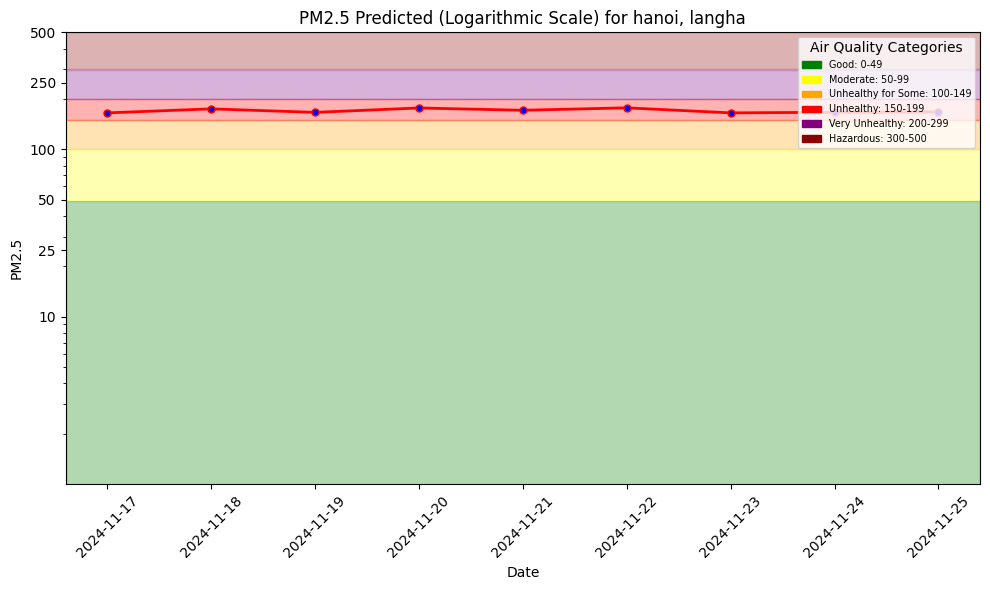

In [20]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [21]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [22]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1161368/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x16cb82e50>, None)

In [23]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day,pm25_lag1,pm25_lag2,pm25_lag3
0,2024-11-13 00:00:00+00:00,26.799999,0.0,11.486200,147.804291,hanoi,145.213898,langha,vietnam,1,163.654755,165.473984,196.251648
1,2024-11-12 00:00:00+00:00,26.100000,0.0,9.199390,149.420853,hanoi,171.795837,langha,vietnam,1,172.000000,159.000000,166.000000
2,2024-11-14 00:00:00+00:00,27.700001,0.0,6.792466,147.994659,hanoi,171.822678,langha,vietnam,1,169.995972,150.690918,147.954254
3,2024-11-16 00:00:00+00:00,27.000000,0.0,10.948973,152.592514,hanoi,112.820793,langha,vietnam,1,127.544991,112.820793,157.000000
4,2024-11-17 00:00:00+00:00,27.299999,0.0,6.369050,137.290634,hanoi,165.094238,langha,vietnam,1,165.094238,127.000000,117.000000


In [24]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.37s) 


,date,pm25,pm25_lag1,pm25_lag2,pm25_lag3,country,city,street,url
0,2018-12-29 00:00:00+00:00,57.0,97.0,118.0,96.0,vietnam,hanoi,langha,https://api.waqi.info/feed/@8641
1,2018-07-25 00:00:00+00:00,64.0,97.0,85.0,47.0,vietnam,hanoi,langha,https://api.waqi.info/feed/@8641
2,2023-10-23 00:00:00+00:00,134.0,108.0,93.0,98.0,vietnam,hanoi,langha,https://api.waqi.info/feed/@8641
3,2020-08-19 00:00:00+00:00,77.0,60.0,65.0,81.0,vietnam,hanoi,langha,https://api.waqi.info/feed/@8641
4,2018-02-13 00:00:00+00:00,190.0,173.0,188.0,178.0,vietnam,hanoi,langha,https://api.waqi.info/feed/@8641
...,...,...,...,...,...,...,...,...,...
2899,2021-09-27 00:00:00+00:00,73.0,72.0,62.0,79.0,vietnam,hanoi,langha,https://api.waqi.info/feed/@8641
2900,2024-11-12 00:00:00+00:00,160.0,172.0,159.0,166.0,vietnam,hanoi,langha,https://api.waqi.info/feed/@8641
2901,2024-11-13 00:00:00+00:00,157.0,157.0,160.0,172.0,vietnam,hanoi,langha,https://api.waqi.info/feed/@8641
2902,2024-11-15 00:00:00+00:00,117.0,117.0,157.0,160.0,vietnam,hanoi,langha,https://api.waqi.info/feed/@8641


In [ ]:
outcome_df = air_quality_df[['date', 'pm25', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]


hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

features_df = weather_fg.read()
features_df = features_df.sort_values(by=['date'], ascending=True)
features_df = features_df.tail(10)

def backfill_predictions_for_monitoring( air_quality_df, monitor_fg, model):
    predict_params = pd.merge(features_df, air_quality_df[['date','pm25', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3','street','country']], on="date")
    predict_params['predicted_pm25'] = model.predict(predict_params[['pm25_lag1', 'pm25_lag2', 'pm25_lag3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    predict_params['days_before_forecast_day'] = 1
    hindcast_df = predict_params
    predict_params = predict_params.drop('pm25', axis=1)

    # convert float to double pm25_lag1, pm25_lag2, pm25_lag3
    predict_params['pm25_lag1'] = predict_params['pm25_lag1'].astype('float64')
    predict_params['pm25_lag2'] = predict_params['pm25_lag2'].astype('float64')
    predict_params['pm25_lag3'] = predict_params['pm25_lag3'].astype('float64')
    monitor_fg.insert(predict_params, write_options={"wait_for_job": True})
    return hindcast_df


# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(air_quality_df, monitor_fg, retrieved_xgboost_model)

hindcast_df

,date,predicted_pm25
0,2024-11-13 00:00:00+00:00,145.213898
1,2024-11-12 00:00:00+00:00,171.795837
2,2024-11-14 00:00:00+00:00,171.822678
3,2024-11-16 00:00:00+00:00,112.820793
4,2024-11-17 00:00:00+00:00,165.094238


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

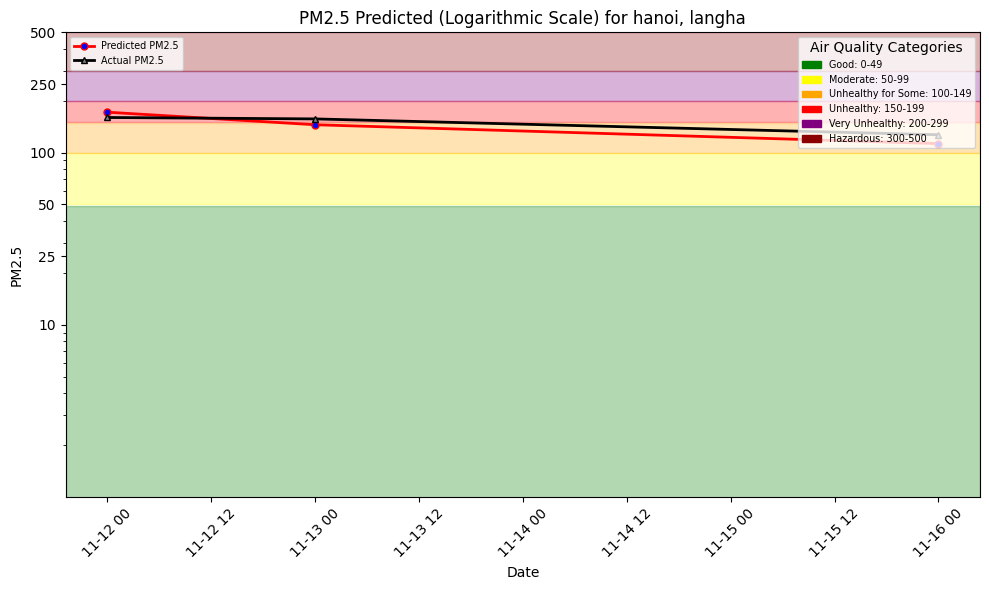

,date,predicted_pm25,pm25,pm25_lag1,pm25_lag2,pm25_lag3
1,2024-11-12 00:00:00+00:00,171.795837,160.0,172.0,159.0,166.0
0,2024-11-13 00:00:00+00:00,145.213898,157.0,157.0,160.0,172.0
2,2024-11-16 00:00:00+00:00,112.820793,127.0,117.0,157.0,160.0


In [ ]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---